In [1]:
!pip install albumentations > /dev/null
!pip install -U efficientnet==0.0.4
import numpy as np
import pandas as pd
import gc
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy
from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add


import glob
import shutil
import os
import random
from PIL import Image
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("black")
os.environ['PYTHONHASHSEED'] = str(seed)
seed = 8
np.random.seed(seed)
tf.set_random_seed(seed)
np.random.seed(seed)
random.seed(seed)

  Created wheel for efficientnet: filename=efficientnet-0.0.4-cp36-none-any.whl size=14289 sha256=7a6dbc9c110a663280c711d9b27549192ef942cdf81d119af6dffdaa3be8bbd2
  Stored in directory: /root/.cache/pip/wheels/5c/34/68/a611a699a28239e964ccf144c0e767cdb5439fee82ec5de6e0
Successfully built efficientnet


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
!unzip -q ../input/data-repack-and-image-statistics/train.zip -d train 
!mkdir masks
!unzip -q ../input/data-repack-and-image-statistics/masks.zip -d masks 
!mkdir train
!unzip -q ../input/data-repack-and-image-statistics/test.zip -d test 
!unzip -q ../input/data-repack-and-image-statistics/train.zip -d train 

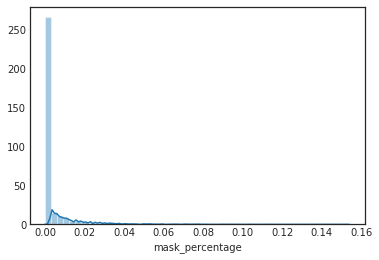

In [3]:
mask_glob = glob.glob('./masks/*')
mask_data = pd.DataFrame()
mask_data['file_names'] = mask_glob
mask_data['mask_percentage'] = 0
mask_data.set_index('file_names')
for item in all_mask_fn:
    mask_data.loc[item,'mask_percentage'] = np.array(Image.open(item)).sum()/(128*128*127) 
mask_data['labels'] = 0
mask_data.loc[mask_data.mask_percentage>0,'labels'] = 1   
sns.distplot(mask_data.mask_percentage)
mask_data.reset_index(inplace=True) # percentage of mask

In [4]:
train_fn = glob.glob('./train/*')
samples = len(train_fn)
idx = np.arange(samples )
train_fn,val_fn = train_test_split(train_fn,stratify=mask_df.labels,test_size=0.1,random_state=11)

print('No. of train files:', len(train_fn))
print('No. of val files:', len(val_fn))

masks_train_fn = [fn.replace('./train','./masks') for i in train_data]    
masks_val_fn = [fn.replace('./train','./masks') for fn in val_data]

No. of train files: 10842
No. of val files: 1205


In [5]:
!mkdir ./keras_im_train
train_dir = './keras_im_train'
!mkdir ./keras_mask_train
train_dir = './keras_mask_train'
for full_fn in masks_train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
for full_fn in train_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    

    
!mkdir ./keras_im_val
train_dir = './keras_im_val'
for full_fn in val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))
    
!mkdir ./keras_mask_val
train_dir = './keras_mask_val'
for full_fn in masks_val_fn:
    fn = full_fn.split('/')[-1]
    shutil.move(full_fn,os.path.join(train_dir,fn))

In [6]:
train_im_path,train_mask_path = './keras_im_train','./keras_mask_train'
h,w,batch_size = 256,256,16

val_im_path,val_mask_path = './keras_im_val','./keras_mask_val'

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train_im_path=train_im_path,train_mask_path=train_mask_path,
                 augmentations=None, batch_size=batch_size,img_size=256, n_channels=3, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.train_im_paths = glob.glob(train_im_path+'/*')
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.augment = augmentations
        self.on_epoch_end()
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path

        self.img_size = img_size
        
       

   

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.train_im_paths))]

        # Find list of IDs
        list_IDs_im = [self.train_im_paths[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_im)

        if self.augment is None:
            return X,np.array(y)/255
        else:            
            im,mask = [],[]   
            for x,y in zip(X,y):
                augmented = self.augment(image=x, mask=y)
                im.append(augmented['image'])
                mask.append(augmented['mask'])
            return np.array(im),np.array(mask)/255
    def __len__(self):
        'Denotes the number of batches per epoch'
        a=len(self.train_im_paths) 
        return int(np.ceil(len(self.train_im_paths) / self.batch_size))
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        b=len(self.train_im_paths)
        self.indexes = np.arange(b)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_im):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        y = np.empty((len(list_IDs_im),self.img_size,self.img_size, 1))
        X = np.empty((len(list_IDs_im),self.img_size,self.img_size, self.n_channels))
      

        # Generate data
        for i, im_path in enumerate(list_IDs_im):
            
            im = np.array(Image.open(im_path))
            mask_path = im_path.replace(self.train_im_path,self.train_mask_path)
            
            mask = np.array(Image.open(mask_path))
            
            
            if len(im.shape)==2:
                im = np.repeat(im[...,None],3,2)

#             # Resize sample
            X[i,] = cv2.resize(im,(self.img_size,self.img_size))

            # Store class
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[..., np.newaxis]
            y[y>0] = 255

        return np.uint8(X),np.uint8(y)

In [7]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    OneOf([
        RandomContrast(),
        RandomGamma(),
        RandomBrightness(),
         ], p=0.3),
    OneOf([
        ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(),
        OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    RandomSizedCrop(min_max_height=(176, 256), height=h, width=w,p=0.25),
    ToFloat(max_value=1)
],p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=1)
],p=1)

# Train Set Images with Masks

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

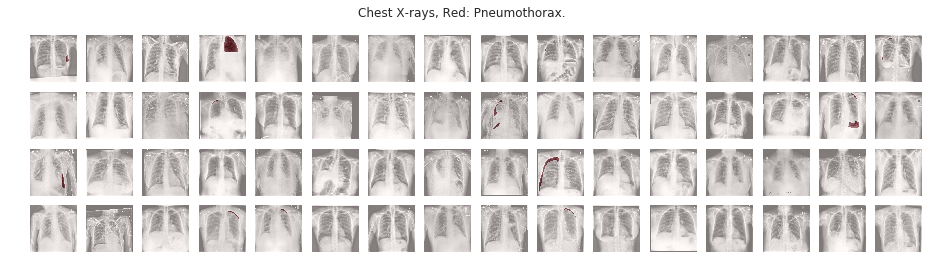

In [8]:
a = DataGenerator(batch_size=64,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.7, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Images after Augmentations

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

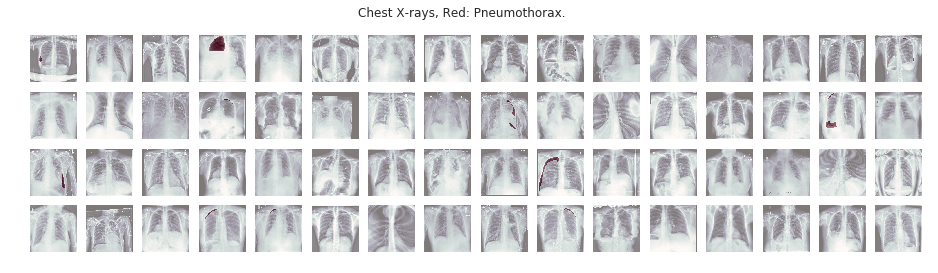

In [9]:
a = DataGenerator(batch_size=64,augmentations=AUGMENTATIONS_TRAIN,shuffle=False)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[:,:,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

# Calculating IOU

In [10]:
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.py_func(get_iou_vector, [label, pred > 0.5], tf.float64)

# Defining Dice Loss

In [11]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

# Define Learning Rate Scheduler
using cosine annealing for learning rate

In [12]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

# Useful Model Blocks

In [13]:
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    if activation == True:
        x = LeakyReLU(alpha=0.1)(x)
    return x

def residual_block(blockInput, num_filters=16):
    x = LeakyReLU(alpha=0.1)(blockInput)
    x = BatchNormalization()(x)
    blockInput = BatchNormalization()(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    return x

# Defining UEfficientNet Model

As mentioned above, this model uses pretrained EfficientNetB4 model as encoder. I use Residual blocks in the decoder part.

In [14]:
from efficientnet import EfficientNetB4

def UEfficientNet(input_shape=(None, None, 3),dropout_rate=0.1):

    backbone = EfficientNetB4(weights='imagenet',
                            include_top=False,
                            input_shape=input_shape)
    input = backbone.input
    neurons = 8

    conv4 = backbone.layers[342].output
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)
    
  
   
    
    uconv4 = Conv2D(neurons * 16, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,neurons * 16)
    uconv4 = LeakyReLU(alpha=0.1)(uconv4)  #conv1_2
    
    deconv3 = Conv2DTranspose(neurons * 8, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3_up1 = Conv2DTranspose(neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3)
    deconv3_up2 = Conv2DTranspose(neurons * 8, (3, 3), strides=(2, 2), padding="same")(deconv3_up1)
    conv3 = backbone.layers[154].output
    uconv3 = concatenate([deconv3,deconv4_up1, conv3])    
    uconv3 = Dropout(dropout_rate)(uconv3)
    
     convm = Conv2D(neurons * 32, (3, 3), activation=None, padding="same",name='conv_middle')(pool4)
    convm = residual_block(convm,neurons * 32)
    convm = residual_block(convm,neurons * 32)
    convm = LeakyReLU(alpha=0.1)(convm)
     # Middle
    deconv4 = Conv2DTranspose(neurons * 16, (3, 3), strides=(2, 2), padding="same")(convm)
    deconv4_up1 = Conv2DTranspose(neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4)
    deconv4_up2 = Conv2DTranspose(neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up1)
    deconv4_up3 = Conv2DTranspose(neurons * 16, (3, 3), strides=(2, 2), padding="same")(deconv4_up2)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4) 
    
    uconv3 = Conv2D(neurons * 8, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,neurons * 8)
    uconv3 = residual_block(uconv3,neurons * 8)
    uconv3 = LeakyReLU(alpha=0.1)(uconv3)

    deconv2 = Conv2DTranspose(neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv3)
    deconv2_up1 = Conv2DTranspose(neurons * 4, (3, 3), strides=(2, 2), padding="same")(deconv2)
    conv2 = backbone.layers[92].output
    uconv2 = concatenate([deconv2,deconv3_up1,deconv4_up2, conv2])
        
    uconv2 = Dropout(0.1)(uconv2)
    uconv2 = Conv2D(neurons * 4, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,neurons * 4)

    uconv2 = LeakyReLU(alpha=0.1)(uconv2)

    uconv1 = Dropout(0.1)(uconv1)
    uconv1 = Conv2D(neurons * 2, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,neurons * 2)

    uconv1 = LeakyReLU(alpha=0.1)(uconv1)
    
    
    deconv1 = Conv2DTranspose(neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    conv1 = backbone.layers[30].output
    uconv1 = concatenate([deconv1,deconv2_up1,deconv3_up2,deconv4_up3, conv1])
    uconv0 = Dropout(dropout_rate/2)(uconv0)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv0)    
    
    
    uconv0 = Conv2DTranspose(neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv1)   
    uconv0 = Dropout(0.1)(uconv0)
    uconv0 = Conv2D(neurons * 1, (3, 3), activation=None, padding="same")(uconv0)
    uconv0 = residual_block(uconv0,neurons * 1)
    uconv0 = LeakyReLU(alpha=0.1)(uconv0)
    model = Model(input, output_layer)
    model.name = 'u-xception'

    return model

In [15]:
K.clear_session()
img_size = 256
model = UEfficientNet(input_shape=(img_size,img_size,3),dropout_rate=0.5)

71720960/71719528 [==============================] - 3s 0us/step


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 128, 128, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [18]:
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[my_iou_metric])

# Training Begins

In [19]:
epochs = 70
snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)
batch_size = 16
valid_im_path,valid_mask_path = './keras_im_val','./keras_mask_val'
# Generators
training_generator = DataGenerator(augmentations=AUGMENTATIONS_TRAIN,img_size=img_size)
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size)

history = model.fit_generator(generator=training_generator,
                            validation_data=validation_generator,                            
                            use_multiprocessing=False,
                            epochs=epochs,verbose=2,
                            callbacks=snapshot.get_callbacks())

Stochastic weight averaging selected for last 3 epochs.
Epoch 1/70


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


 - 412s - loss: 1.2116 - my_iou_metric: 1.8437e-04 - val_loss: 0.9723 - val_my_iou_metric: 0.6002

Epoch 00001: val_my_iou_metric improved from -inf to 0.60017, saving model to ./keras.model
Epoch 2/70
 - 373s - loss: 0.9973 - my_iou_metric: 0.0135 - val_loss: 0.9473 - val_my_iou_metric: 0.1446

Epoch 00002: val_my_iou_metric did not improve from 0.60017
Epoch 3/70
 - 373s - loss: 0.8745 - my_iou_metric: 0.2538 - val_loss: 0.6733 - val_my_iou_metric: 0.6200

Epoch 00003: val_my_iou_metric improved from 0.60017 to 0.62000, saving model to ./keras.model
Epoch 4/70
 - 373s - loss: 0.7998 - my_iou_metric: 0.4336 - val_loss: 0.6785 - val_my_iou_metric: 0.5167

Epoch 00004: val_my_iou_metric did not improve from 0.62000
Epoch 5/70
 - 373s - loss: 0.7528 - my_iou_metric: 0.5557 - val_loss: 0.6151 - val_my_iou_metric: 0.6836

Epoch 00005: val_my_iou_metric improved from 0.62000 to 0.68357, saving model to ./keras.model
Epoch 6/70
 - 373s - loss: 0.7106 - my_iou_metric: 0.6045 - val_loss: 0.657

0

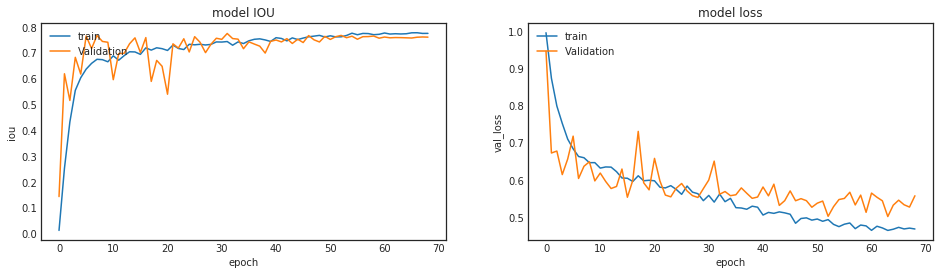

In [20]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
gc.collect()

In [21]:
# Load best model or swa model if not available
try:
    print('using swa weight model')
    model.load_weights('./keras_swa.model')
except Exception as e:
    print(e)
    model.load_weights('./keras.model')

using swa weight model


# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [22]:
def predict_result(model,validation_generator,img_size): 
    # TBD predict both orginal and reflect x
    preds_test1 = model.predict_generator(validation_generator).reshape(-1, img_size, img_size)
    return preds_test1

In [23]:
validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size,shuffle=False)

AUGMENTATIONS_TEST_FLIPPED = Compose([
    HorizontalFlip(p=1),
    ToFloat(max_value=1)
],p=1)

validation_generator_flipped = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST_FLIPPED,
                                     img_size=img_size,shuffle=False)

preds_valid_orig = predict_result(model,validation_generator,img_size)
preds_valid_flipped = predict_result(model,validation_generator_flipped,img_size)
preds_valid_flipped = np.array([np.fliplr(x) for x in preds_valid_flipped])
preds_valid = 0.5*preds_valid_orig + 0.5*preds_valid_flipped

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


In [24]:
valid_fn = glob.glob('./keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

# Plot some predictions for validation set images

Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

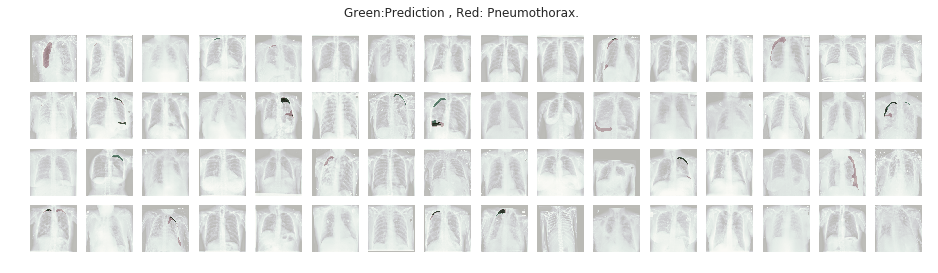

In [25]:
threshold_best = 0.5
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size,batch_size=64,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.")

In [26]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

valid_fn = glob.glob('./keras_mask_val/*')
y_valid_ori = np.array([cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in valid_fn])
assert y_valid_ori.shape == preds_valid.shape

In [27]:
## Scoring for last model
thresholds = np.linspace(0.2, 0.9, 31)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

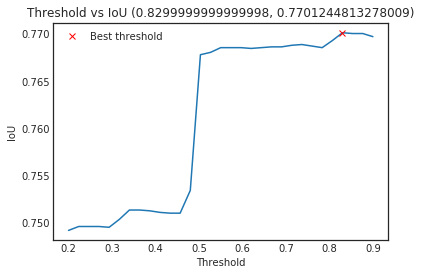

In [28]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in greater


Text(0.5, 0.98, 'Green:Prediction , Red: Pneumothorax.')

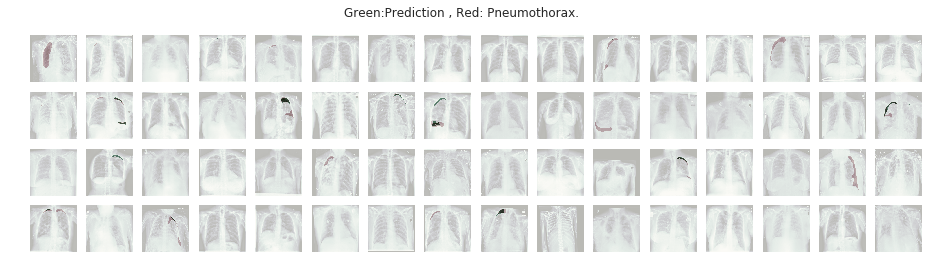

In [29]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

validation_generator = DataGenerator(train_im_path = valid_im_path ,
                                     train_mask_path=valid_mask_path,augmentations=AUGMENTATIONS_TEST,
                                     img_size=img_size,batch_size=64,shuffle=False)

images,masks = validation_generator.__getitem__(0)
for i,(im, mask) in enumerate(zip(images,masks)):
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im[...,0], cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.5, cmap="Greens")
    ax.axis('off')
plt.suptitle("Green:Prediction , Red: Pneumothorax.")

# Test Set Prediction

In [30]:
test_fn = glob.glob('./test/*')
x_test = [cv2.resize(np.array(Image.open(fn)),(img_size,img_size)) for fn in test_fn]
x_test = np.array(x_test)
x_test = np.array([np.repeat(im[...,None],3,2) for im in x_test])
print(x_test.shape)
preds_test_orig = model.predict(x_test,batch_size=batch_size)

x_test = np.array([np.fliplr(x) for x in x_test])
preds_test_flipped = model.predict(x_test,batch_size=batch_size)
preds_test_flipped = np.array([np.fliplr(x) for x in preds_test_flipped])

preds_test = 0.5*preds_test_orig + 0.5*preds_test_flipped

# del x_test; gc.collect()

(3205, 256, 256, 3)


# Some Test Set Predictions

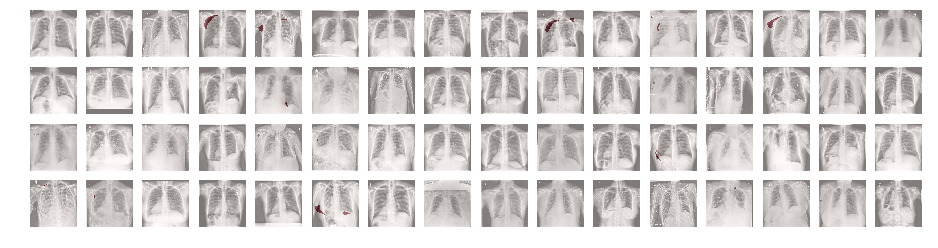

In [31]:
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
# for i, idx in enumerate(index_val[:max_images]):
for i, idx in enumerate(test_fn[:max_images]):
    img = x_test[i]
    pred = preds_test[i].squeeze()
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(np.array(np.round(pred > threshold_best).T, dtype=np.float32), alpha=0.5, cmap="Reds")
    ax.axis('off')

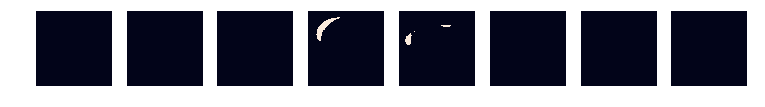

In [32]:
import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')

from mask_functions import rle2mask,mask2rle
import pdb

# Generate rle encodings (images are first converted to the original size)
rles = []
i,max_img = 1,10
plt.figure(figsize=(16,4))
for p in tqdm_notebook(preds_test):
    p = p.squeeze()
    im = cv2.resize(p,(1024,1024))
    im = im > threshold_best
#     zero out the smaller regions.
    if im.sum()<1024*2:
        im[:] = 0
    im = (im.T*255).astype(np.uint8)  
    rles.append(mask2rle(im, 1024, 1024))
    i += 1
    if i<max_img:
        plt.subplot(1,max_img,i)
        plt.imshow(im)
        plt.axis('off')